# Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# DỮ LIỆU

## GIÁ CÀ PHÊ

In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data/gia_ca_phe_den_2023.csv', encoding='ISO-8859-1')
df_coffee.tail()

,date,price
6203,12/27/2023,68000.0
6204,12/28/2023,68850.0
6205,12/29/2023,70000.0
6206,12/30/2023,68200.0
6207,12/31/2023,68200.0


In [ ]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6208 non-null   object 
 1   price   6208 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.1+ KB


In [ ]:
df_coffee['date'] = pd.to_datetime(df_coffee['date'])
df_coffee.set_index('date', inplace=True)

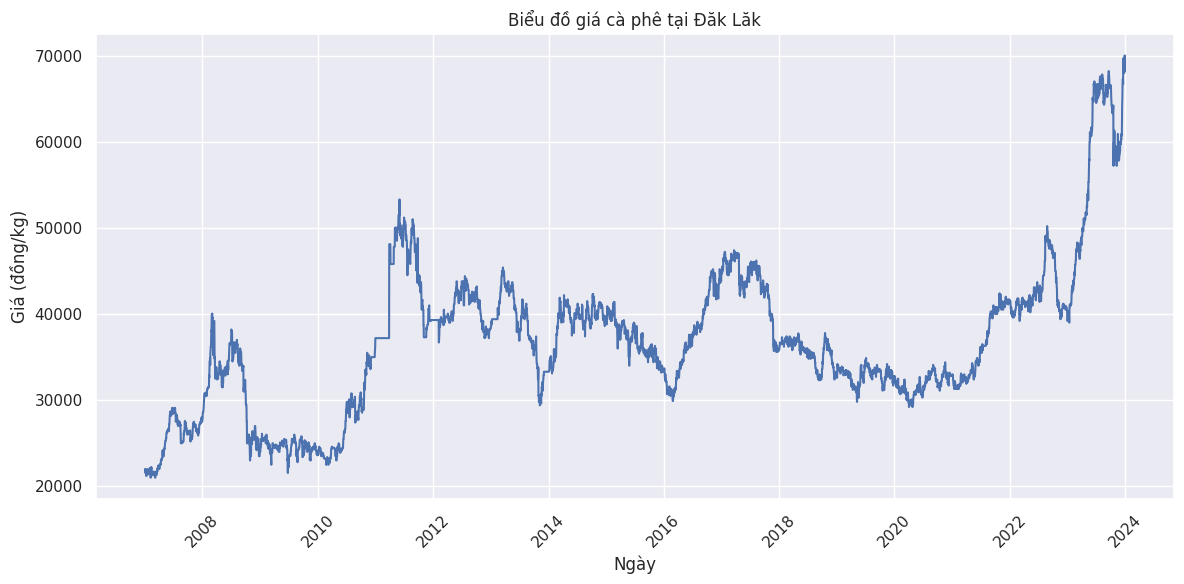

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mô hình dự đoán đơn biến

## Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(df_coffee['price'].values.reshape(-1, 1))

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_price, seq_length)

In [ ]:
X.shape, y.shape

((6178, 30, 1), (6178, 1))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (4942, 30, 1) (4942, 1)
Kích thước tập kiểm tra: (1236, 30, 1) (1236, 1)


In [ ]:
model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(GRU(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
78/78 [==============================] - 25s 134ms/step - loss: 0.0056
Epoch 2/50
78/78 [==============================] - 6s 82ms/step - loss: 8.9602e-04
Epoch 3/50
78/78 [==============================] - 8s 108ms/step - loss: 7.4542e-04
Epoch 4/50
78/78 [==============================] - 6s 82ms/step - loss: 7.1326e-04
Epoch 5/50
78/78 [==============================] - 8s 106ms/step - loss: 6.6141e-04
Epoch 6/50
78/78 [==============================] - 6s 81ms/step - loss: 6.1845e-04
Epoch 7/50
78/78 [==============================] - 8s 101ms/step - loss: 6.0650e-04
Epoch 8/50
78/78 [==============================] - 6s 81ms/step - loss: 5.7741e-04
Epoch 9/50
78/78 [==============================] - 8s 102ms/step - loss: 5.6761e-04
Epoch 10/50
78/78 [==============================] - 7s 88ms/step - loss: 5.5178e-04
Epoch 11/50
78/78 [==============================] - 8s 96ms/step - loss: 5.0257e-04
Epoch 12/50
78/78 [==============================] - 7s 94ms/step - loss

## Dự đoán tập train

In [ ]:
train_predictions = model.predict(X_train)

155/155 [==============================] - 4s 18ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 510.67
Training MAPE: 1.08%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình GRU)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Dự đoán tập test

In [ ]:
test_predictions = model.predict(X_test)

39/39 [==============================] - 1s 14ms/step


In [ ]:
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {train_mape:.2f}%')

Testing RMSE: 531.46
Testing MAPE: 1.08%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_test)], y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(test_predictions)], y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình GRU)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  510.67      1.08
1   Test  531.46      0.77


## Lưu mô hình



In [ ]:
# from tensorflow.keras.models import load_model

# model.save('LSTM_coffee_daklak.h5')